## Skinthesia Classification Model

## Import Library

In [329]:
import re
import ast
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, f1_score, hamming_loss, jaccard_score

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Load Data

In [330]:
# Load the CSV file
df = pd.read_csv('../data/products_integrated_features.csv', encoding='ISO-8859-1')
df.head()

,url,image,product_name,brand,category,price,rating,skin_type,total_reviews,skin_concern,ingredients,ingredient_category,skin_goal,age,rating_star
0,https://reviews.femaledaily.com/products/treat...,https://image.femaledaily.com/dyn/210/images/p...,Acne Gel,Verile,Acne treatment,20000,3.7,"['combination', 'oily']",81477,"['acne', 'blackheads']","['niacinamide', 'licorice, niacinamide', 'niac...","['acne', 'brightening']","['brightening', 'hydrating']",19 - 24,4.343434
1,https://reviews.femaledaily.com/products/treat...,https://image.femaledaily.com/dyn/300/remaster...,Acne Patch,Derma Angel,Acne treatment,43000,4.1,"['combination', 'oily']",131694,"['sensitive', 'irritation']","['niacinamide', 'tea tree', 'salicylic acid']","['acne', 'brightening']","['hydrating', 'smoothing']",19 - 24,4.695035
2,https://reviews.femaledaily.com/products/clean...,https://image.femaledaily.com/dyn/210/images/p...,Bright Complete Brightening Face Wash Foam,Garnier,Facial Wash,27000,3.2,"['combination', 'normal']",127058,"['acne', 'redness']","['salicylic acid, vitamin c', 'vitamin c', 'sa...","['acne', 'brightening']","['calming', 'fast-absorbing']",19 - 24,4.316832
3,https://reviews.femaledaily.com/products/treat...,https://image.femaledaily.com/dyn/210/images/p...,CL,Benzolac,Acne treatment,32000,3.8,"['combination', 'oily']",22718,"['pores', 'blackheads']","['niacinamide', 'niacinamide, salicylic acid',...","['acne', 'brightening']","['pore-minimizing', 'brightening']",19 - 24,4.405405
4,https://reviews.femaledaily.com/products/treat...,https://image.femaledaily.com/dyn/210/images/p...,Acne Care Lotion,Sariayu,Acne treatment,48000,3.6,"['combination', 'oily']",4998,"['dryness', 'sensitive']","['bha', 'tea tree', 'retinol', 'centella asiat...","['acne', 'calming']","['barrier-repair', 'calming']",25 - 29,4.264706


## Data Selection

In [331]:
# Mengambil kolom yang relevan
# df = df[['skin_type','skin_concern','skin_goal','ingredients', 'ingredient_category']]
df = df[['skin_type','skin_concern','skin_goal','ingredient_category']]
df.head()

,skin_type,skin_concern,skin_goal,ingredient_category
0,"['combination', 'oily']","['acne', 'blackheads']","['brightening', 'hydrating']","['acne', 'brightening']"
1,"['combination', 'oily']","['sensitive', 'irritation']","['hydrating', 'smoothing']","['acne', 'brightening']"
2,"['combination', 'normal']","['acne', 'redness']","['calming', 'fast-absorbing']","['acne', 'brightening']"
3,"['combination', 'oily']","['pores', 'blackheads']","['pore-minimizing', 'brightening']","['acne', 'brightening']"
4,"['combination', 'oily']","['dryness', 'sensitive']","['barrier-repair', 'calming']","['acne', 'calming']"


In [332]:
# Information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   skin_type            908 non-null    object
 1   skin_concern         908 non-null    object
 2   skin_goal            908 non-null    object
 3   ingredient_category  885 non-null    object
dtypes: object(4)
memory usage: 28.5+ KB


## Data Cleaning & Parsing

In [333]:
# Menggunakan ast untuk evaluasi literal
# Fungsi flatten list
def flatten_list(nested_lst):
    flat = []
    for item in nested_lst:
        if isinstance(item, list):
            flat.extend(flatten_list(item))
        else:
            flat.append(item)
    return flat

# Fungsi untuk parsing dan membersihkan data
def parse_and_clean(cell):
    # Cek kalau sudah list langsung pakai
    if isinstance(cell, list):
        lst = cell
    # Kalau string, coba literal_eval ke list Python
    elif isinstance(cell, str):
        try:
            lst = ast.literal_eval(cell)
        except:
            lst = [cell]
    # Tangani nilai NaN
    elif pd.isna(cell):
        return []
    else:
        # Kalau bukan list/string/NaN, jadikan string dalam list
        lst = [str(cell)]

    # Flatten nested list
    flat_list = flatten_list(lst)

    # Split elemen dengan koma
    split_list = []
    for item in flat_list:
        if isinstance(item, str):
            parts = [part.strip() for part in item.split(',')]
            split_list.extend(parts)
        else:
            split_list.append(str(item).strip())

    # Normalisasi dan hapus duplikat
    seen = set()
    result = []
    for item in split_list:
        item_norm = re.sub(r'[\[\]\'\"]', '', item.lower().strip())
        if item_norm and item_norm not in seen:
            seen.add(item_norm)
            result.append(item_norm)

    return result


In [334]:
# Apply the parsing and cleaning function to each column
cols = df.columns
for col in cols:
    df[col] = df[col].apply(parse_and_clean)

df.head()

,skin_type,skin_concern,skin_goal,ingredient_category
0,"[combination, oily]","[acne, blackheads]","[brightening, hydrating]","[acne, brightening]"
1,"[combination, oily]","[sensitive, irritation]","[hydrating, smoothing]","[acne, brightening]"
2,"[combination, normal]","[acne, redness]","[calming, fast-absorbing]","[acne, brightening]"
3,"[combination, oily]","[pores, blackheads]","[pore-minimizing, brightening]","[acne, brightening]"
4,"[combination, oily]","[dryness, sensitive]","[barrier-repair, calming]","[acne, calming]"


In [335]:
# Cek berapa banyak list kosong di tiap kolom
for col in df.columns:
    empty_count = df[col].apply(lambda x: isinstance(x, list) and len(x) == 0).sum()
    print(f"{col}: {empty_count} list kosong")
print()

# Cek jumlah unknown
total = len(df)
for col in cols:
    count = df[col].apply(lambda x: 'unknown' in x).sum()
    percent = count / total * 100
    print(f"{col}: {count} baris ({percent:.2f}%) mengandung 'unknown'")

skin_type: 0 list kosong
skin_concern: 0 list kosong
skin_goal: 0 list kosong
ingredient_category: 23 list kosong

skin_type: 0 baris (0.00%) mengandung 'unknown'
skin_concern: 0 baris (0.00%) mengandung 'unknown'
skin_goal: 0 baris (0.00%) mengandung 'unknown'
ingredient_category: 0 baris (0.00%) mengandung 'unknown'


In [336]:
# # Hapus baris yang hanya mengandung 'unknown' di kolom ingredients
# df_cleaned = df[df['ingredients'].apply(lambda x: x != ['unknown'])].reset_index(drop=True)

# Hapus baris yang nan atau kosong di kolom ingredients category
# df_cleaned = df_cleaned[df_cleaned['ingredient_category'].apply(lambda x: isinstance(x, list) and len(x) > 0)].reset_index(drop=True)
df_cleaned = df[df['ingredient_category'].apply(lambda x: isinstance(x, list) and len(x) > 0)].reset_index(drop=True)


df_cleaned.head()

,skin_type,skin_concern,skin_goal,ingredient_category
0,"[combination, oily]","[acne, blackheads]","[brightening, hydrating]","[acne, brightening]"
1,"[combination, oily]","[sensitive, irritation]","[hydrating, smoothing]","[acne, brightening]"
2,"[combination, normal]","[acne, redness]","[calming, fast-absorbing]","[acne, brightening]"
3,"[combination, oily]","[pores, blackheads]","[pore-minimizing, brightening]","[acne, brightening]"
4,"[combination, oily]","[dryness, sensitive]","[barrier-repair, calming]","[acne, calming]"


## Visualisasi Data

In [337]:
# Flatten semua list di kolom ingredients, ingredient_category, skin_type, skin_concern, dan skin_goal
all_ingredients_category = [item for sublist in df_cleaned['ingredient_category'] for item in sublist]
# all_ingredients = [item for sublist in df_cleaned['ingredients'] for item in sublist]
all_skin_types = [item for sublist in df_cleaned['skin_type'] for item in sublist]
all_skin_concerns = [item for sublist in df_cleaned['skin_concern'] for item in sublist]
all_skin_goals = [item for sublist in df_cleaned['skin_goal'] for item in sublist]

# Hitung frekuensi kemunculan setiap ingredient category, ingredient, skin type, skin concern, dan skin goal
ingredient_category_counts = Counter(all_ingredients_category)
# ingredient_counts = Counter(all_ingredients)
skin_type_counts = Counter(all_skin_types)
skin_concern_counts = Counter(all_skin_concerns)
skin_goal_counts = Counter(all_skin_goals)

# Tampilkan berapa banyak tiap kategori, ingredient, skin type, skin concern, dan skin goal yang unik
print(f"Jumlah unik ingredient categories: {len(ingredient_category_counts)}")
# print(f"Jumlah unik ingredients: {len(ingredient_counts)}")
print(f"Jumlah unik skin types: {len(skin_type_counts)}")
print(f"Jumlah unik skin concerns: {len(skin_concern_counts)}")
print(f"Jumlah unik skin goals: {len(skin_goal_counts)}")

Jumlah unik ingredient categories: 6
Jumlah unik skin types: 4
Jumlah unik skin concerns: 15
Jumlah unik skin goals: 20


In [338]:
# Tampilkan jumlah kemunculan tiap kategori, ingredient, skin type, skin concern, dan skin goal
print("\nJumlah kemunculan tiap ingredient category:")
for ingredient_category, count in ingredient_category_counts.items():
    print(f"{ingredient_category}: {count} kali")


Jumlah kemunculan tiap ingredient category:
acne: 94 kali
brightening: 472 kali
calming: 128 kali
exfoliant: 81 kali
hydrating: 397 kali
anti_aging: 74 kali


In [339]:

# print("\nJumlah kemunculan tiap ingredient:")
# for ingredient, count in ingredient_counts.items():
#     print(f"{ingredient}: {count} kali")


In [340]:
print("\nJumlah kemunculan tiap skin type:")
for skin_type, count in skin_type_counts.items():
    print(f"{skin_type}: {count} kali")



Jumlah kemunculan tiap skin type:
combination: 870 kali
oily: 621 kali
normal: 114 kali
dry: 162 kali


In [341]:
print("\nJumlah kemunculan tiap skin concern:")
for skin_concern, count in skin_concern_counts.items():
    print(f"{skin_concern}: {count} kali")



Jumlah kemunculan tiap skin concern:
acne: 579 kali
blackheads: 82 kali
sensitive: 367 kali
irritation: 135 kali
redness: 73 kali
pores: 97 kali
dryness: 214 kali
fine lines: 33 kali
wrinkles: 21 kali
oiliness: 62 kali
hyperpigmentation: 8 kali
tiny bumps: 19 kali
dark spots: 21 kali
whiteheads: 3 kali
dull skin: 39 kali


In [342]:
print("\nJumlah kemunculan tiap skin goal:")
for skin_goal, count in skin_goal_counts.items():
    print(f"{skin_goal}: {count} kali")


Jumlah kemunculan tiap skin goal:
brightening: 374 kali
hydrating: 526 kali
smoothing: 50 kali
calming: 295 kali
fast-absorbing: 107 kali
pore-minimizing: 13 kali
barrier-repair: 23 kali
tone-evening: 24 kali
glowing: 62 kali
oil-control: 64 kali
non-comedogenic: 5 kali
nourishing: 24 kali
scar-fading: 30 kali
refreshing: 23 kali
regenerating: 19 kali
plumping: 29 kali
healthy: 13 kali
lightweight: 11 kali
anti-aging: 28 kali
firming: 7 kali


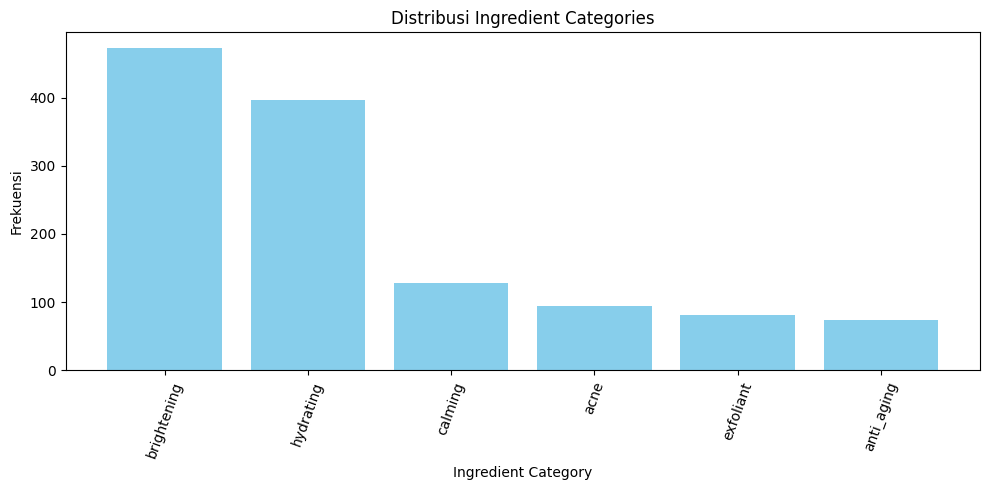

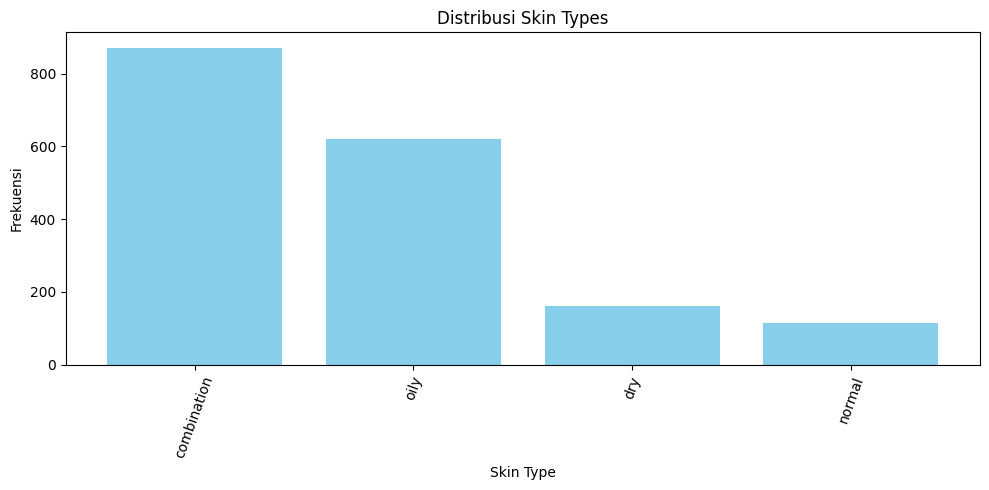

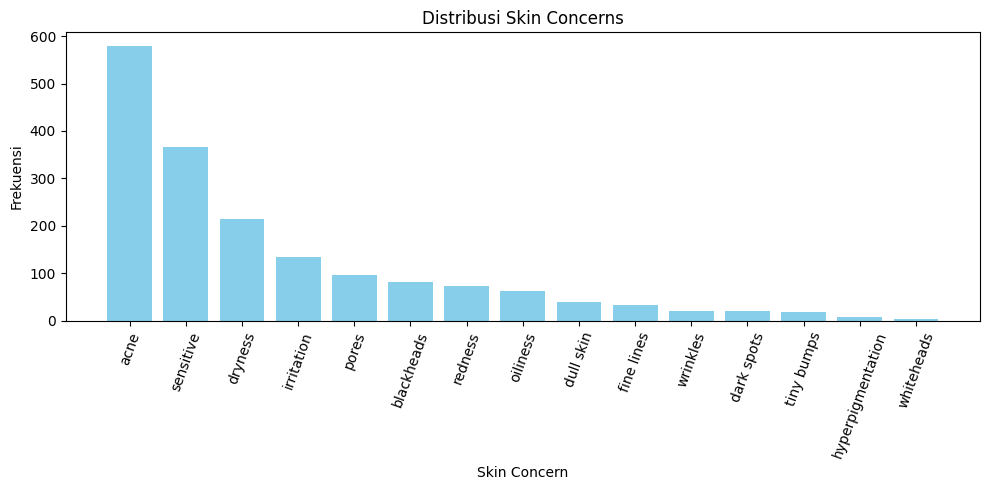

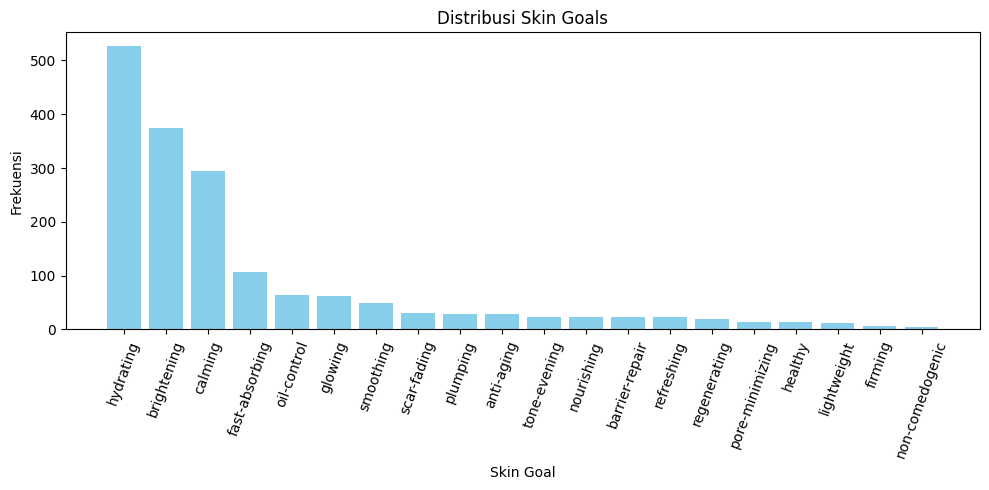

In [343]:
# Visualisasi distribusi skin types, concerns, dan goals
def plot_distribution(data, title, xlabel, ylabel):
    counts = Counter(data)
    # Urutkan berdasarkan nilai (frekuensi), descending
    sorted_items = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    labels, values = zip(*sorted_items)
    
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color='skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show()
    
plot_distribution(all_ingredients_category, 'Distribusi Ingredient Categories', 'Ingredient Category', 'Frekuensi')
# plot_distribution(all_ingredients, 'Distribusi Ingredients', 'Ingredient', 'Frekuensi')
plot_distribution(all_skin_types, 'Distribusi Skin Types', 'Skin Type', 'Frekuensi')
plot_distribution(all_skin_concerns, 'Distribusi Skin Concerns', 'Skin Concern', 'Frekuensi')
plot_distribution(all_skin_goals, 'Distribusi Skin Goals', 'Skin Goal', 'Frekuensi')

## Preprocesing Data & Encoding

In [344]:
# Inisialisasi MultiLabelBinarizer untuk tiap fitur dan label
mlb_skin_type = MultiLabelBinarizer()
mlb_skin_concern = MultiLabelBinarizer()
mlb_skin_goal = MultiLabelBinarizer()
# mlb_ingredients = MultiLabelBinarizer()
mlb_ingredients_category = MultiLabelBinarizer()

# Fit-transform fitur input dan label (ubah jadi multi-hot vectors)
X_skin_type = mlb_skin_type.fit_transform(df_cleaned['skin_type'])
X_skin_concern = mlb_skin_concern.fit_transform(df_cleaned['skin_concern'])
X_skin_goal = mlb_skin_goal.fit_transform(df_cleaned['skin_goal'])
# X_ingredients = mlb_ingredients.fit_transform(df_cleaned['ingredients'])
Y_ingredient_category = mlb_ingredients_category.fit_transform(df_cleaned['ingredient_category'])

# Gabungkan semua fitur input jadi satu matriks fitur
# X = np.hstack([X_skin_type, X_skin_concern, X_skin_goal, X_ingredients])
X = np.hstack([X_skin_type, X_skin_concern, X_skin_goal])

print("Shape fitur input:", X.shape)
print("Shape label (ingredients):", Y_ingredient_category.shape)

Shape fitur input: (885, 39)
Shape label (ingredients): (885, 6)


In [345]:
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Buat vocab (index mapping)
def make_vocab(col):
    vocab = set([item for sublist in col for item in sublist])
    return {v: i+1 for i, v in enumerate(sorted(vocab))}  # padding=0

vocab_skin_type = make_vocab(df_cleaned['skin_type'])
vocab_skin_concern = make_vocab(df_cleaned['skin_concern'])
vocab_skin_goal = make_vocab(df_cleaned['skin_goal'])

def encode_sequence(col, vocab):
    return col.apply(lambda x: [vocab[i] for i in x if i in vocab])

X_skin_type = encode_sequence(df_cleaned['skin_type'], vocab_skin_type)
X_skin_concern = encode_sequence(df_cleaned['skin_concern'], vocab_skin_concern)
X_skin_goal = encode_sequence(df_cleaned['skin_goal'], vocab_skin_goal)

# Pad sequences (top-2, jadi maxlen=2)
X_skin_type = pad_sequences(X_skin_type, maxlen=2)
X_skin_concern = pad_sequences(X_skin_concern, maxlen=2)
X_skin_goal = pad_sequences(X_skin_goal, maxlen=2)

# Label (Y tetap pakai MultiLabelBinarizer)
mlb_ingredient_category = MultiLabelBinarizer()
y_final = mlb_ingredient_category.fit_transform(df_cleaned['ingredient_category'])

In [346]:
X_train_type, X_test_type, \
X_train_concern, X_test_concern, \
X_train_goal, X_test_goal, \
y_train, y_test = train_test_split(
    X_skin_type, X_skin_concern, X_skin_goal, y_final,
    test_size=0.2, random_state=42
)

In [347]:
import numpy as np
from sklearn.utils import shuffle

def duplicate_minority_to_target(Xs, y, target_count=300):
    """
    Duplicate samples from minority classes to reach at least target_count positives per class.
    
    Parameters:
    - Xs: list of input arrays (e.g., [X_type, X_concern, X_goal])
    - y: multilabel binary matrix (shape: n_samples, n_classes)
    - target_count: int, desired minimum count per class
    
    Returns:
    - tuple: (X1_aug, X2_aug, ..., y_aug)
    """
    Xs_aug = [x.copy() for x in Xs]
    y_aug = y.copy()

    for i in range(y.shape[1]):
        current_count = np.sum(y_aug[:, i])
        if current_count >= target_count:
            continue  # skip label already meeting the target

        # cari index yang punya label positif (1)
        idxs = np.where(y[:, i] == 1)[0]
        if len(idxs) == 0:
            continue  # skip if no positive example at all

        needed = int(target_count - current_count)
        repeats = (needed // len(idxs)) + 1

        for _ in range(repeats):
            for j in idxs:
                if np.sum(y_aug[:, i]) >= target_count:
                    break
                for k in range(len(Xs)):
                    Xs_aug[k] = np.concatenate([Xs_aug[k], Xs[k][j][None]], axis=0)
                y_aug = np.vstack([y_aug, y[j][None]])

    # shuffle before returning
    shuffled = shuffle(*Xs_aug, y_aug, random_state=42)
    Xs_aug = shuffled[:-1]  # semua kecuali terakhir (fitur)
    y_aug = shuffled[-1]    # label di posisi terakhir
    return tuple(Xs_aug) + (y_aug,)



In [348]:
X_train_type_aug, X_train_concern_aug, X_train_goal_aug, y_train_aug = duplicate_minority_to_target(
    [X_train_type, X_train_concern, X_train_goal], y_train, target_count=300
)

print("Shape X_train_type_aug:", X_train_type_aug.shape)
print("Shape X_train_concern_aug:", X_train_concern_aug.shape)
print("Shape X_train_goal_aug:", X_train_goal_aug.shape)
print("Shape y_train_aug:", y_train_aug.shape)

# Distribusi label
print("\nDistribusi label setelah augmentasi:")
for i in range(y_train_aug.shape[1]):
    count = np.sum(y_train_aug[:, i])
    print(f"Label {i} ({mlb_ingredient_category.classes_[i]}): {count} kali")


Shape X_train_type_aug: (1444, 2)
Shape X_train_concern_aug: (1444, 2)
Shape X_train_goal_aug: (1444, 2)
Shape y_train_aug: (1444, 6)

Distribusi label setelah augmentasi:
Label 0 (acne): 377 kali
Label 1 (anti_aging): 318 kali
Label 2 (brightening): 509 kali
Label 3 (calming): 316 kali
Label 4 (exfoliant): 300 kali
Label 5 (hydrating): 361 kali


In [350]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = {}
for i, col in enumerate(mlb_ingredient_category.classes_):
    weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),  # fix: ubah jadi numpy array
        y=y_train_aug[:, i]
    )
    class_weights[i] = weights[1]  # ambil weight untuk kelas 1 (positif)


In [362]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow as tf

# Parameter
embedding_dim = 8
num_classes = y_train_aug.shape[1]

input_type = Input(shape=(2,), name='skin_type_input')
input_concern = Input(shape=(2,), name='concern_input')
input_goal = Input(shape=(2,), name='goal_input')

embed_type = Embedding(input_dim=len(vocab_skin_type) + 1, output_dim=embedding_dim)(input_type)
embed_concern = Embedding(input_dim=len(vocab_skin_concern) + 1, output_dim=embedding_dim)(input_concern)
embed_goal = Embedding(input_dim=len(vocab_skin_goal) + 1, output_dim=embedding_dim)(input_goal)

flat_type = Flatten()(embed_type)
flat_concern = Flatten()(embed_concern)
flat_goal = Flatten()(embed_goal)

concat = Concatenate()([flat_type, flat_concern, flat_goal])
dense = Dense(64, activation='relu')(concat)
output = Dense(num_classes, activation='sigmoid')(dense)

model = Model(inputs=[input_type, input_concern, input_goal], outputs=output)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=['accuracy']
)
model.summary()



Model: "functional_132"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ skin_type_input     │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concern_input       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ goal_input          │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_13        │ (None, 2, 8)      │         40 │ skin_type_input[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_14        │ (None, 2, 8)      │        128 │ concern_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_15        │ (None, 2, 8)      │        168 │ goal_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 16)        │          0 │ embedding_13[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_13          │ (None, 16)        │          0 │ embedding_14[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 16)        │          0 │ embedding_15[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 48)        │          0 │ flatten_12[0][0], │
│ (Concatenate)       │                   │            │ flatten_13[0][0], │
│                     │                   │            │ flatten_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_298 (Dense)   │ (None, 64)        │      3,136 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_299 (Dense)   │ (None, 6)         │        390 │ dense_298[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,862 (15.09 KB)

 Trainable params: 3,862 (15.09 KB)

 Non-trainable params: 0 (0.00 B)

In [363]:
# Hitung sample weight manual untuk setiap label positif
sample_weights = np.ones(y_train_aug.shape[0], dtype=np.float32)
for i in range(num_classes):
    sample_weights += y_train_aug[:, i] * class_weights[i]


history = model.fit(
    x={
        'skin_type_input': X_train_type_aug,
        'concern_input': X_train_concern_aug,
        'goal_input': X_train_goal_aug,
    },
    y=y_train_aug,
    sample_weight=sample_weights,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)



Epoch 1/20


/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['skin_type_input', 'concern_input', 'goal_input']. Received: the structure of inputs={'skin_type_input': '*', 'concern_input': '*', 'goal_input': '*'}
  warnings.warn(
2025-06-08 09:07:20.410077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: indices[0,1] = 7 is not in [0, 5)
	 [[{{function_node __inference_one_step_on_data_1536943}}{{node functional_132_1/embedding_13_1/GatherV2}}]]


InvalidArgumentError: Graph execution error:

Detected at node functional_132_1/embedding_13_1/GatherV2 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code

  File "/var/folders/pv/hl8lt53s3212m50jmr0nb5q00000gp/T/ipykernel_20834/525365496.py", line 7, in <module>

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/models/functional.py", line 182, in call

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/models/functional.py", line 584, in call

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/layers/core/embedding.py", line 140, in call

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/ops/numpy.py", line 5206, in take

  File "/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/backend/tensorflow/numpy.py", line 2029, in take

indices[0,1] = 7 is not in [0, 5)
	 [[{{node functional_132_1/embedding_13_1/GatherV2}}]] [Op:__inference_one_step_on_iterator_1537002]

In [ ]:
from sklearn.metrics import classification_report

y_pred_proba = model.predict([X_test_type, X_test_concern, X_test_goal])
y_pred = (y_pred_proba >= 0.5).astype(int)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=mlb_ingredient_category.classes_))

# metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    hamming = hamming_loss(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred, average='weighted')

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'hamming_loss': hamming,
        'jaccard_score': jaccard
    }
metrics = calculate_metrics(y_test, y_pred)
print("\nMetrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

In [316]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Input dimension dari masing-masing vocab
vocab_size_type = len(vocab_skin_type) + 1
vocab_size_concern = len(vocab_skin_concern) + 1
vocab_size_goal = len(vocab_skin_goal) + 1

embedding_dim = 8  # bisa dituning

# Input layers
input_type = Input(shape=(2,), name='skin_type')
input_concern = Input(shape=(2,), name='skin_concern')
input_goal = Input(shape=(2,), name='skin_goal')

# Embedding + Flatten
embed_type = Embedding(vocab_size_type, embedding_dim)(input_type)
embed_concern = Embedding(vocab_size_concern, embedding_dim)(input_concern)
embed_goal = Embedding(vocab_size_goal, embedding_dim)(input_goal)

flat_type = Flatten()(embed_type)
flat_concern = Flatten()(embed_concern)
flat_goal = Flatten()(embed_goal)

# Gabungkan semua
merged = Concatenate()([flat_type, flat_concern, flat_goal])

# Dense layers
x = Dense(128, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

output = Dense(y_final.shape[1], activation='sigmoid')(x)

# Compile
model = Model(inputs=[input_type, input_concern, input_goal], outputs=output)
model.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)
model.summary()


Model: "functional_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ skin_type           │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skin_concern        │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skin_goal           │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 2, 8)      │         40 │ skin_type[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 2, 8)      │        128 │ skin_concern[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 2, 8)      │        168 │ skin_goal[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 16)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 16)        │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 48)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_289 (Dense)   │ (None, 128)       │      6,272 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_289[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_211         │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_290 (Dense)   │ (None, 64)        │      8,256 │ dropout_211[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_290[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_212         │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_291 (Dense)   │ (None, 6)         │        390 │ dropout_212[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,022 (62.59 KB)

 Trainable params: 15,638 (61.09 KB)

 Non-trainable params: 384 (1.50 KB)

In [319]:
from sklearn.model_selection import train_test_split

X_train_type, X_test_type, \
X_train_concern, X_test_concern, \
X_train_goal, X_test_goal, \
y_train, y_test = train_test_split(
    X_skin_type, X_skin_concern, X_skin_goal, y_final,
    test_size=0.2, random_state=42
)

history = model.fit(
    [X_train_type, X_train_concern, X_train_goal], y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.8458 - loss: 0.3478 - val_binary_accuracy: 0.7653 - val_loss: 0.4900
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - binary_accuracy: 0.8432 - loss: 0.3535 - val_binary_accuracy: 0.7746 - val_loss: 0.4901
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - binary_accuracy: 0.8477 - loss: 0.3263 - val_binary_accuracy: 0.7700 - val_loss: 0.4932
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.8581 - loss: 0.3294 - val_binary_accuracy: 0.7700 - val_loss: 0.4926
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.8550 - loss: 0.3272 - val_binary_accuracy: 0.7664 - val_loss: 0.4979
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.8521 - loss: 0.3364 - val_binary_accuracy: 0.7629 - val_loss: 0.5024
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_accuracy: 0.8533 - loss: 0.3295 - val_binary_accuracy: 0.7582 - val_loss: 0.5099
Epoch 

In [320]:
# Evaluasi final model di test set
print("\n🔍 Evaluating final model on test set...")

y_pred = model.predict([X_test_type, X_test_concern, X_test_goal])

# Thresholding untuk binary classification
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)
# Print classification report   
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary, target_names=mlb_ingredients_category.classes_))

# Hitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary, average='weighted')
hamming = hamming_loss(y_test, y_pred_binary)
jaccard = jaccard_score(y_test, y_pred_binary, average='weighted')
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Hamming Loss: {hamming:.4f}")
print(f"Jaccard Score: {jaccard:.4f}")


🔍 Evaluating final model on test set...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Classification Report:
              precision    recall  f1-score   support

        acne       0.18      0.26      0.21        19
  anti_aging       0.00      0.00      0.00        15
 brightening       0.56      0.57      0.57        95
     calming       0.00      0.00      0.00        29
   exfoliant       0.00      0.00      0.00        19
   hydrating       0.38      0.43      0.40        67

   micro avg       0.40      0.36      0.38       244
   macro avg       0.19      0.21      0.20       244
weighted avg       0.34      0.36      0.35       244
 samples avg       0.36      0.37      0.35       244


Evaluation Metrics:
Accuracy: 0.1695
F1 Score: 0.3473
Hamming Loss: 0.2702
Jaccard Score: 0.2320


/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Data Splitting

In [280]:
# Split data jadi train/val/test (70:15:15)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, Y_ingredient_category, test_size=0.3, random_state=42, shuffle=True)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (619, 39), (619, 6)
Validation set: (133, 39), (133, 6)
Test set: (133, 39), (133, 6)


## Data Augmentation

In [281]:
# Hitung jumlah sampel tiap label di y_train (multi-label)
print("Jumlah tiap label di train set:")
label_counts = y_train.sum(axis=0)
label_names = mlb_ingredients_category.classes_

df_label_counts = pd.DataFrame({
    'Ingredient Category': label_names,
    'Count_in_train': label_counts
}).sort_values(by='Count_in_train')

print(df_label_counts)

Jumlah tiap label di train set:
  Ingredient Category  Count_in_train
1          anti_aging              54
4           exfoliant              55
0                acne              69
3             calming              85
5           hydrating             283
2         brightening             326


In [282]:
# Fungsi untuk menghitung jumlah label per sampel
def count_labels_per_sample(y_matrix):
    return y_matrix.sum(axis=1)

# Hitung jumlah label per kategori
label_counts = y_train.sum(axis=0).astype(int)
target_per_label = 300  # target baru
label_total = label_counts.copy()

X_aug = []
y_aug = []

In [283]:
# --- Oversample untuk label minor saja (yang < target_per_label) ---
for i, count in enumerate(label_counts):
    if label_total[i] >= target_per_label:
        continue  # label ini sudah cukup jumlahnya

    gap = target_per_label - label_total[i]
    idx = np.where(y_train[:, i] == 1)[0]
    valid_idx = [j for j in idx if y_train[j].sum() <= 2]

    added = 0
    ptr = 0

    while added < gap and ptr < len(valid_idx) * 100:
        j = valid_idx[ptr % len(valid_idx)]
        new_y = y_train[j].copy()
        label_indices = np.where(new_y == 1)[0]

        if (
            all(label_total[k] < target_per_label for k in label_indices)
            or (len(label_indices) == 1 and label_indices[0] == i)
            or (label_total[i] < 0.5 * target_per_label)
        ):
            X_aug.append(X_train[j])
            y_aug.append(new_y)
            for k in label_indices:
                label_total[k] += 1
            added += 1
        ptr += 1

    print(f"Oversample label '{label_names[i]}' → +{added} data")

# Gabungkan data original + data augmentasi
X_all = np.vstack([X_train] + X_aug)
y_all = np.vstack([y_train] + y_aug)

# Validasi max 2 label per sample
valid_mask = np.sum(y_all, axis=1) <= 2
X_final = X_all[valid_mask]
y_final = y_all[valid_mask]

# Shuffle
X_final, y_final = shuffle(X_final, y_final, random_state=42)

# Print hasil akhir
print("\n✅ Setelah oversampling saja dengan max 2 label per data:")
print("X_final:", X_final.shape)
print("y_final:", y_final.shape)

new_counts = y_final.sum(axis=0)
print("\nDistribusi label baru:")
for i, count in enumerate(new_counts):
    print(f"{label_names[i]}: {int(count)}")

Oversample label 'acne' → +231 data
Oversample label 'anti_aging' → +235 data
Oversample label 'calming' → +115 data
Oversample label 'exfoliant' → +159 data

✅ Setelah oversampling saja dengan max 2 label per data:
X_final: (1359, 39)
y_final: (1359, 6)

Distribusi label baru:
acne: 310
anti_aging: 300
brightening: 353
calming: 301
exfoliant: 300
hydrating: 300


## Modelling Pipeline

In [284]:
# Gunakan hasil augmentasi
input_dim = X_final.shape[1]
output_dim = y_final.shape[1]

# Hitung class weights (inverse frequency) dari y_final
freq = np.sum(y_final, axis=0)
total = y_final.shape[0]
class_weights_np = total / (freq + 1e-6)
class_weights_np = class_weights_np / np.max(class_weights_np)  # Normalisasi
class_weights_tf = tf.constant(class_weights_np, dtype=tf.float32)

print("Class weights:", class_weights_np)

Class weights: [0.96774194 1.         0.84985836 0.99667774 1.         1.        ]


In [285]:
# Loss function dengan class weights
def weighted_binary_crossentropy(y_true, y_pred):
    bce = K.binary_crossentropy(y_true, y_pred)
    weight_vector = y_true * class_weights_tf + (1 - y_true) * 1.0
    weighted_bce = bce * weight_vector
    return K.mean(weighted_bce)

In [259]:
# Focal loss function
def binary_focal_loss(gamma=2., alpha=0.25):
    def focal_loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = K.pow(1. - p_t, gamma)

        return K.mean(-alpha_factor * modulating_factor * K.log(p_t))
    return focal_loss

In [286]:
# Build model
def build_model(input_dim, output_dim, lr=0.001, dropout_rate=0.4): 
    model = Sequential([
        Input(shape=(input_dim,)),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(output_dim, activation='sigmoid')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        loss=weighted_binary_crossentropy,
        optimizer=optimizer,
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model

# Model summary
model = build_model(input_dim, output_dim)
model.summary()

Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_237 (Dense)               │ (None, 256)            │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_172         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_172 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_238 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_173         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_173 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_239 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_174         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_174 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_240 (Dense)               │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,574 (209.27 KB)

 Trainable params: 52,678 (205.77 KB)

 Non-trainable params: 896 (3.50 KB)

In [296]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Manual hyperparameter tuning
best_f1 = 0
best_params = {}

for lr in [0.001, 0.0005]:
    for batch_size in [32, 64]:
        print(f"\n==============================================")
        print(f"Training model with lr={lr}, batch_size={batch_size}")
        print(f"==============================================\n")
        
        model = build_model(input_dim, output_dim, lr=lr, dropout_rate=0.3)
        history = model.fit(
            X_final, y_final,
            epochs=500,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=1
        )

        # Evaluasi di test set
        y_pred_probs = model.predict(X_test)

        # Cari threshold terbaik per class
        thresholds = np.arange(0.1, 0.9, 0.05)
        best_thresholds = []
        for i in range(output_dim):
            f1_scores = []
            for t in thresholds:
                preds = (y_pred_probs[:, i] > t).astype(int)
                f1 = f1_score(y_test[:, i], preds)
                f1_scores.append(f1)
            best_t = thresholds[np.argmax(f1_scores)]
            best_thresholds.append(best_t)

        print("Best thresholds per class:", best_thresholds)

        y_pred = np.zeros_like(y_pred_probs, dtype=int)
        for i in range(output_dim):
            y_pred[:, i] = (y_pred_probs[:, i] > best_thresholds[i]).astype(int)

        f1_macro = f1_score(y_test, y_pred, average='macro')
        print(f"F1 macro score on test: {f1_macro:.4f}")

        if f1_macro > best_f1:
            best_f1 = f1_macro
            best_params = {'lr': lr, 'batch_size': batch_size, 'thresholds': best_thresholds}
            best_model = model
            best_y_pred = y_pred


Training model with lr=0.001, batch_size=32

Epoch 1/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - auc: 0.5432 - binary_accuracy: 0.5216 - loss: 0.8747 - precision: 0.2419 - recall: 0.5251 - val_auc: 0.6077 - val_binary_accuracy: 0.7310 - val_loss: 0.6386 - val_precision: 0.3038 - val_recall: 0.1273
Epoch 2/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6475 - binary_accuracy: 0.6052 - loss: 0.7072 - precision: 0.3142 - recall: 0.6132 - val_auc: 0.6371 - val_binary_accuracy: 0.7665 - val_loss: 0.6039 - val_precision: 0.4524 - val_recall: 0.0504
Epoch 3/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6843 - binary_accuracy: 0.6433 - loss: 0.6554 - precision: 0.3480 - recall: 0.6216 - val_auc: 0.6520 - val_binary_accuracy: 0.7770 - val_loss: 0.5761 - val_precision: 0.7407 - val_recall: 0.0531
Epoch 4/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.7125 - binary_accuracy: 0.6853 - loss: 0.5991 - precision: 0.3794 - recall: 0.5992 - val_auc: 0.6591 - val_binary_accuracy: 0

In [297]:
print("\n=== ✅ Best Hyperparameters ===")
print(best_params)
print(f"Best F1 macro score: {best_f1:.4f}")


=== ✅ Best Hyperparameters ===
{'lr': 0.0005, 'batch_size': 32, 'thresholds': [0.5500000000000002, 0.45000000000000007, 0.1, 0.40000000000000013, 0.5000000000000001, 0.1]}
Best F1 macro score: 0.4049


## Evaluation

In [298]:
# Evaluasi final model di test set
print("\n🔍 Evaluating final model on test set...")

final_probs = best_model.predict(X_test)
final_pred = np.zeros_like(final_probs, dtype=int)
for i in range(output_dim):
    final_pred[:, i] = (final_probs[:, i] > best_params['thresholds'][i]).astype(int)

print("\n📊 Final classification report:")
print(classification_report(y_test, final_pred, zero_division=0))


🔍 Evaluating final model on test set...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

📊 Final classification report:
              precision    recall  f1-score   support

           0       0.56      0.33      0.42        15
           1       0.16      0.54      0.24        13
           2       0.48      1.00      0.65        64
           3       0.21      0.91      0.34        23
           4       0.12      0.57      0.20        14
           5       0.41      1.00      0.58        54

   micro avg       0.33      0.87      0.48       183
   macro avg       0.32      0.73      0.40       183
weighted avg       0.38      0.87      0.51       183
 samples avg       0.33      0.87      0.47       183



In [299]:
# Print final metrics
print("\n📈 Final Metrics:")
print("🎯 Accuracy Score (subset accuracy):", accuracy_score(y_test, best_y_pred))
print("🤝 F1 Score (macro):", f1_score(y_test, best_y_pred, average='macro'))
print("🤝 F1 Score (micro):", f1_score(y_test, best_y_pred, average='micro'))
print("🤝 F1 Score (weighted):", f1_score(y_test, best_y_pred, average='weighted'))
print("⚖️ Hamming Loss:", hamming_loss(y_test, best_y_pred))
print("📏 Jaccard Score (samples):", jaccard_score(y_test, best_y_pred, average='samples'))


📈 Final Metrics:
🎯 Accuracy Score (subset accuracy): 0.015037593984962405
🤝 F1 Score (macro): 0.4049324286564557
🤝 F1 Score (micro): 0.47604790419161674
🤝 F1 Score (weighted): 0.5075239668958839
⚖️ Hamming Loss: 0.43859649122807015
📏 Jaccard Score (samples): 0.32944862155388466


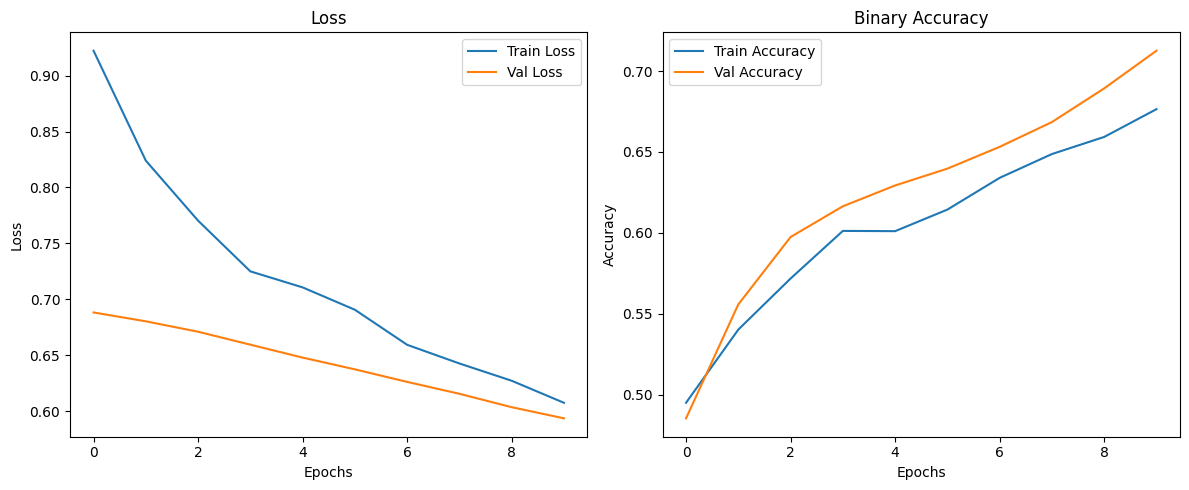

In [291]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Val Accuracy')
    plt.title('Binary Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

## Save Model

In [216]:
# Simpan model TensorFlow ke folder models
model.save('../src/models/ingredients_category_classification_model.keras')

# Simpan MultiLabelBinarizer pakai pickle
with open('../src/models/ingredients_category_mlb.pkl', 'wb') as f:
    pickle.dump(mlb_ingredients_category, f)

## Inference Model

In [232]:
# --- LOAD MODEL DAN ENCODER ---
model = load_model("../src/models/ingredients_category_classification_model.keras",
                   custom_objects={'weighted_binary_crossentropy': weighted_binary_crossentropy})  
with open("../src/models/ingredients_category_mlb.pkl", "rb") as f:
    mlb = pickle.load(f)

# --- HELPER UNTUK NORMALISASI INPUT ---
def clean_input(lst):
    if isinstance(lst, str):
        lst = [lst]
    seen = set()
    result = []
    for item in lst:
        item_norm = re.sub(r"[\\[\\]\'\"]", "", item.lower().strip())
        if item_norm and item_norm not in seen:
            seen.add(item_norm)
            result.append(item_norm)
    return result

# --- FUNGSI UNTUK INFERENCE ---
def predict_ingredient_categories(skin_type, skin_concern, skin_goal, ingredients, threshold=0.3):
    # Normalisasi input
    skin_type = clean_input(skin_type)
    skin_concern = clean_input(skin_concern)
    skin_goal = clean_input(skin_goal)
    ingredients = clean_input(ingredients)

    # Buat vector multi-hot per fitur
    vec_skin_type = np.array([1 if c in skin_type else 0 for c in mlb_skin_type.classes_])
    vec_skin_concern = np.array([1 if c in skin_concern else 0 for c in mlb_skin_concern.classes_])
    vec_skin_goal = np.array([1 if c in skin_goal else 0 for c in mlb_skin_goal.classes_])
    vec_ingredients = np.array([1 if c in ingredients else 0 for c in mlb_ingredients.classes_])

    # Gabungkan semua fitur jadi input vector sepanjang 60
    input_vector = np.concatenate([vec_skin_type, vec_skin_concern, vec_skin_goal, vec_ingredients]).reshape(1, -1).astype(np.float32)

    # Prediksi
    probs = model.predict(input_vector)[0]

    # Ambil label kategori bahan aktif dengan probabilitas >= threshold
    predicted_labels = [label for label, prob in zip(mlb_ingredients_category.classes_, probs) if prob >= threshold]

    return predicted_labels

In [234]:
result = predict_ingredient_categories(
    skin_type=['dry'],
    skin_concern=['acne'],
    skin_goal=['hydration'],
    ingredients=['salicylic acid', 'hyaluronic acid']
)

print("Rekomendasi ingredients:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
Rekomendasi ingredients: ['acne', 'anti_aging', 'brightening', 'calming', 'exfoliant', 'hydrating']
